In [1]:
import numpy as np

# How to use logging


Estimagic can keep a persistent log of the parameter and criterion values tried out by an optimizer in a sqlite database. 

The sqlite database is also used to exchange data between the optimization and the dashboard.

## Turn logging on or off

To enable logging, it suffices to provide a path to an sqlite database when calling maximize or minimize. The database does not have to exist, estimagic will generate it for you. 

In [2]:
from estimagic import minimize


def sphere(params):
    return params @ params


res = minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    logging="my_log.db",
)

## Make logging faster

By default, we use a very safe mode of sqlite that makes it almost impossible to corrupt the database. Even if your computer is suddenly shut down or unplugged. 

However, this makes log writing a bit slower, which becomes notable when the criterion function is very fast. 

In that case, you can enable fast_logging, which is still quite safe!

In [3]:
res = minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    logging="my_log.db",
    log_options={"fast_logging": True},
)

## Handling existing tables

By default, we only append to databases and do not overwrite data in them. You have a few options to change this:

In [4]:
res = minimize(
    criterion=sphere,
    params=np.arange(5),
    algorithm="scipy_lbfgsb",
    logging="my_log.db",
    log_options={
        "if_database_exists": "replace",  # one of "raise", "replace", "extend",
        "if_table_exists": "replace",  # one of "raise", "replace", "extend"
    },
)

## Reading the log

In [5]:
from estimagic import OptimizeLogReader

reader = OptimizeLogReader("my_log.db")

Read the start params

In [6]:
reader.read_start_params()

array([0, 1, 2, 3, 4])

Read a specific iteration (use -1 for the last)

In [7]:
reader.read_iteration(-1)

{'rowid': 3,
 'params': array([ 0.00000000e+00, -2.19792136e-07, -4.01986529e-08, -1.26862247e-07,
        -2.06263028e-07]),
 'internal_derivative': array([ 1.49011612e-09, -4.38094157e-07, -7.89071896e-08, -2.52234378e-07,
        -4.11035941e-07]),
 'timestamp': 30105.1584116,
 'exceptions': None,
 'valid': True,
 'hash': None,
 'value': 1.08562981500731e-13,
 'step': 1,
 'criterion_eval': 1.08562981500731e-13}

Read the full history

In [8]:
reader.read_history().keys()

dict_keys(['params', 'criterion', 'runtime'])

## Plot the history from a log

In [9]:
from estimagic import criterion_plot, params_plot

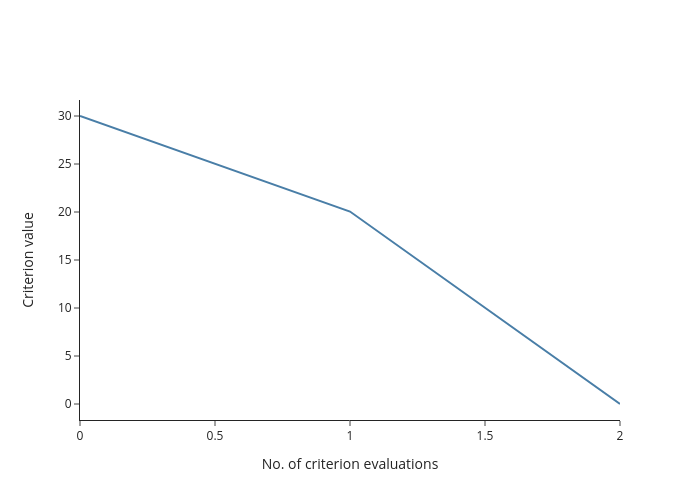

In [10]:
fig = criterion_plot("my_log.db")
fig.show(renderer="png")

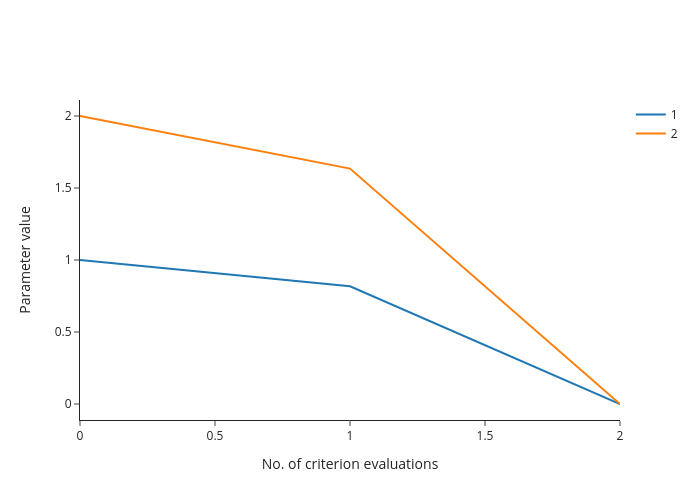

In [11]:
fig = params_plot("my_log.db", selector=lambda x: x[1:3])
fig.show(renderer="png")